In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, random
from tabulate import tabulate
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from keras import applications
import gc
import tensorflow as tf
from skimage import data, io, filters
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [70]:
gc.collect()

9870

In [71]:
base_path  = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

classes = os.listdir(base_path)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


**Transformation to tensor**

In [79]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(base_path, transform = transformations)


In [82]:
random_seed = 42
torch.manual_seed(random_seed)

**Visualising initial data**

In [83]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

**We have equal poplulation of all classes of data**

Text(0, 0.5, 'population')

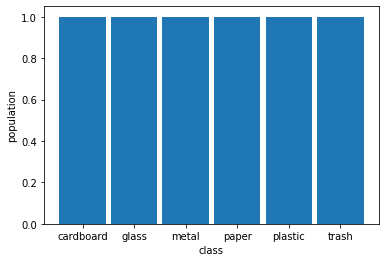

In [84]:
plt.hist(dataset.classes, bins=np.arange(7)-0.5, rwidth=0.9)
plt.xlabel('class')
plt.ylabel('population')

In [85]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [86]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

**Creating Modelbase**

In [87]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [88]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

**Porting to GPU**

In [89]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [90]:
device = get_default_device()
device

device(type='cuda')

In [91]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


**Training model**

In [92]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [93]:
model = to_device(ResNet(), device)

In [94]:
evaluate(model, val_dl)

{'val_loss': 1.7843793630599976, 'val_acc': 0.2083333283662796}

In [95]:
num_epochs =8
opt_func = torch.optim.Adamax
lr = 5.5e-5


In [96]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.5566, val_loss: 1.3885, val_acc: 0.7812
Epoch 2: train_loss: 1.3071, val_loss: 1.2672, val_acc: 0.8490
Epoch 3: train_loss: 1.1969, val_loss: 1.1929, val_acc: 0.9132
Epoch 4: train_loss: 1.1352, val_loss: 1.1628, val_acc: 0.9462
Epoch 5: train_loss: 1.1000, val_loss: 1.1414, val_acc: 0.9618
Epoch 6: train_loss: 1.0819, val_loss: 1.1282, val_acc: 0.9566
Epoch 7: train_loss: 1.0728, val_loss: 1.1235, val_acc: 0.9635
Epoch 8: train_loss: 1.0707, val_loss: 1.1159, val_acc: 0.9566


**Trying cross validation**

**Plots for accuracy, loss and epochs**

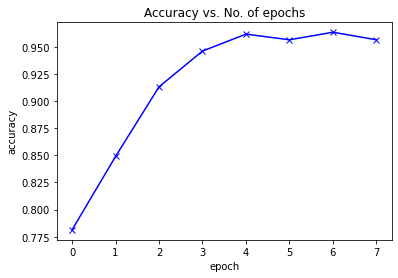

In [99]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

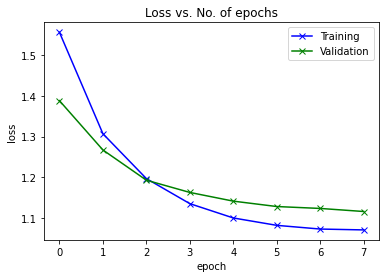

In [100]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-gx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

**Visualizing final Predictions**

In [101]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: plastic , Predicted: plastic


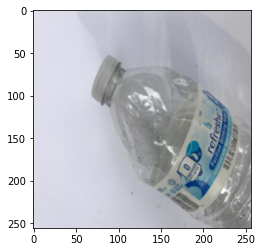

In [102]:
img, label = test_ds[42]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))